# Elective 3 - ML Comparison

### Description
Comparison of 3 machine learning classifier models with Dota 2 radiant and dire hero lineup and score (total kills) win prediction

In [100]:
# libs
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from hashlib import sha256
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, auc, classification_report

In [101]:
# load dataset and show first 10
json_path = 'simple_match_set.json'
with open(json_path, 'r') as file:
    data : List = json.load(file)

df = pd.DataFrame(data)
df.head(10)

,radiant_score,dire_score,radiant_lineup,dire_lineup,radiant_win
0,26,11,"[48, 72, 87, 92, 104]","[25, 62, 74, 100, 136]",True
1,4,25,"[1, 7, 51, 73, 99]","[30, 35, 93, 100, 120]",False
2,41,19,"[11, 22, 97, 106, 123]","[1, 75, 82, 88, 114]",True
3,8,30,"[9, 54, 96, 128, 137]","[7, 38, 91, 112, 136]",False
4,37,5,"[7, 14, 48, 99, 111]","[17, 61, 86, 110, 136]",True
5,41,21,"[11, 14, 23, 39, 79]","[6, 36, 67, 71, 136]",True
6,39,23,"[7, 10, 37, 59, 119]","[6, 23, 51, 76, 79]",True
7,24,10,"[22, 37, 44, 47, 131]","[6, 21, 38, 68, 99]",True
8,36,2,"[8, 73, 79, 98, 119]","[14, 35, 61, 91, 108]",True
9,24,57,"[2, 73, 106, 123, 131]","[7, 26, 30, 44, 97]",False


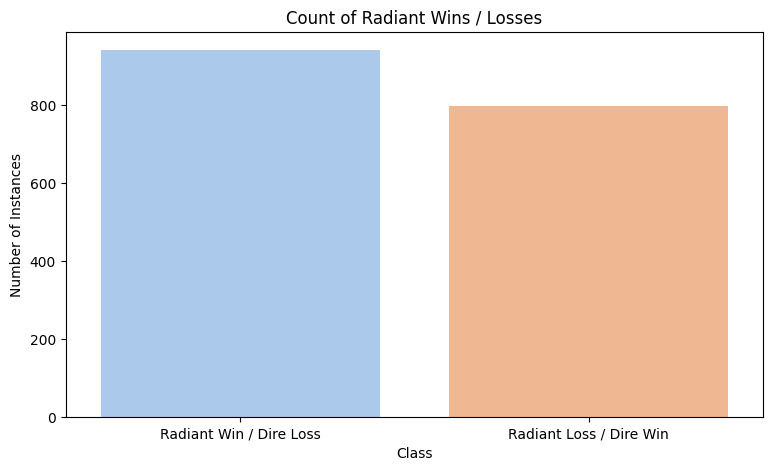

In [96]:
class_counts = df['radiant_win'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']
class_counts['Class'] = class_counts['Class'].map({True: 'Radiant Win / Dire Loss', False: 'Radiant Loss / Dire Win'})

plt.figure(figsize=(9, 5))
sns.barplot(data=class_counts, x='Class', y='Count', palette='pastel', hue='Class')
plt.title('Count of Radiant Wins / Losses')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

In [97]:
# 'flattens' an array (in this case the combination of heroes in a team)
# returns a random float generated using a seed (an int of the hashed array)
def randfloat_from_arr(arr, min_val=0, max_val=1.0):
    arr.sort()
    arr_hash = sha256(str(arr).encode()).hexdigest()
    seed = int(arr_hash, 16)
    random.seed(seed)
    return random.uniform(min_val, max_val)

df['radiant_lineup'] = df['radiant_lineup'].apply(lambda x: randfloat_from_arr(x, 0, 100.0))
df['dire_lineup'] = df['dire_lineup'].apply(lambda x: randfloat_from_arr(x, 0, 100.0))
df['radiant_win'] = df['radiant_win'].astype(int)

X = df.drop(columns=['radiant_win'])
y = df['radiant_win'].astype(int)

df.head()

# training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}
results = []

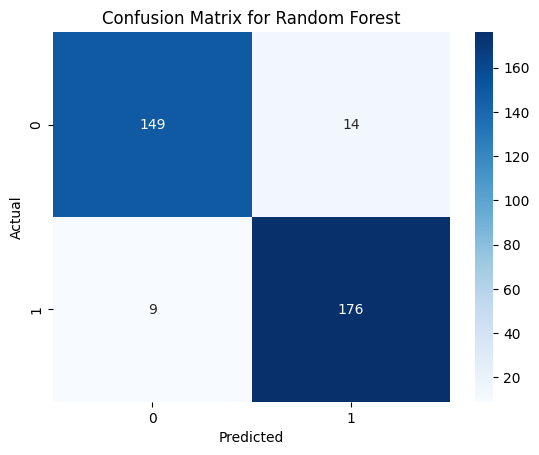

Random Forest Confusion Matrix Scores:
True Postiives:176
True Negatives:149
False Positives:14
False Negatives:9

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93       163
           1       0.93      0.95      0.94       185

    accuracy                           0.93       348
   macro avg       0.93      0.93      0.93       348
weighted avg       0.93      0.93      0.93       348



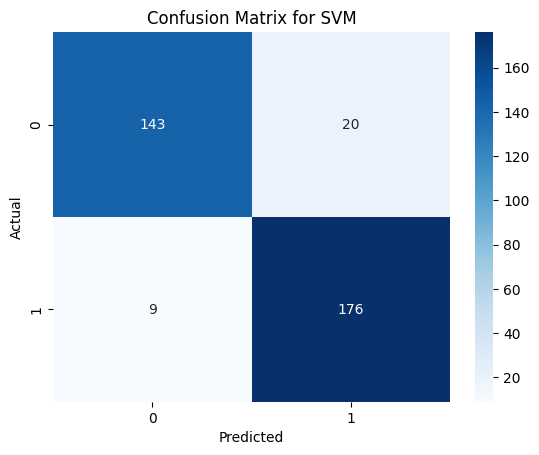

SVM Confusion Matrix Scores:
True Postiives:176
True Negatives:143
False Positives:20
False Negatives:9

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       163
           1       0.90      0.95      0.92       185

    accuracy                           0.92       348
   macro avg       0.92      0.91      0.92       348
weighted avg       0.92      0.92      0.92       348



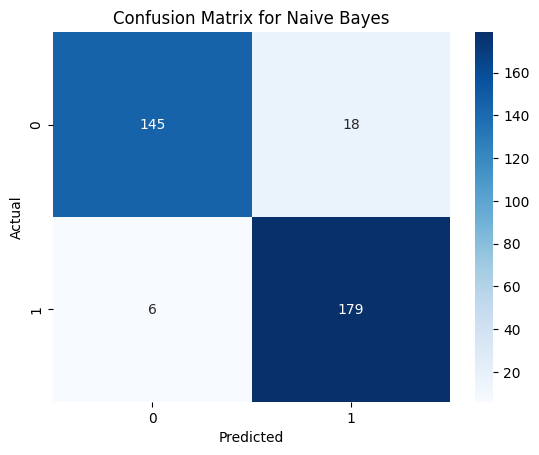

Naive Bayes Confusion Matrix Scores:
True Postiives:179
True Negatives:145
False Positives:18
False Negatives:6

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       163
           1       0.91      0.97      0.94       185

    accuracy                           0.93       348
   macro avg       0.93      0.93      0.93       348
weighted avg       0.93      0.93      0.93       348



In [98]:
# training and evaluation of models
for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)

    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    results.append({'Model': model_name, 'Metric': 'Accuracy', 'Score': accuracy})
    results.append({'Model': model_name, 'Metric': 'Precision', 'Score': precision})
    results.append({'Model': model_name, 'Metric': 'Recall (Sensitivity)', 'Score': recall})
    results.append({'Model': model_name, 'Metric': 'Specificity', 'Score': specificity})
    results.append({'Model': model_name, 'Metric': 'F1 Score', 'Score': f1})

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print(f"{model_name} Confusion Matrix Scores:\nTrue Postiives:{tp}\nTrue Negatives:{tn}\nFalse Positives:{fp}\nFalse Negatives:{fn}\n")
    print(f"{model_name} Classification Report:\n", classification_report(y_test, y_pred))

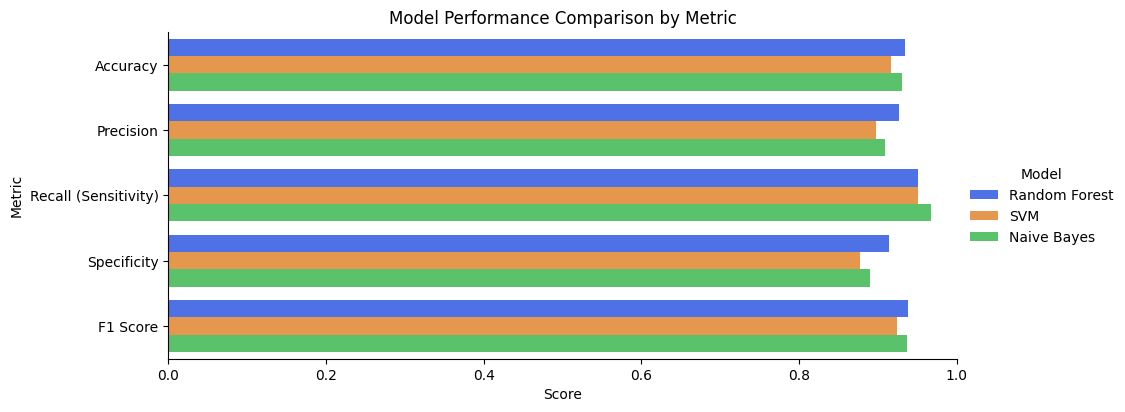

In [99]:
results_df = pd.DataFrame(results)

sns.catplot(data=results_df, y='Metric', x='Score', hue='Model', kind='bar', palette='bright', alpha=0.8, height=4, aspect=2.5)
plt.title('Model Performance Comparison by Metric')
plt.xlim(0, 1)
plt.xlabel('Score')
plt.ylabel('Metric')
plt.show()